https://www.kaggle.com/code/sufya6/bengaluru-house-price-prediction-model-99-09

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder,StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor , GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score
import joblib,json,math

In [6]:
df = pd.read_csv('bengaluru_house_prices.csv')
df.head(4)

,area_type,availability,location,size,society,total_sqft,bath,balcony,price
0,Super built-up Area,19-Dec,Electronic City Phase II,2 BHK,Coomee,1056,2.0,1.0,39.07
1,Plot Area,Ready To Move,Chikka Tirupathi,4 Bedroom,Theanmp,2600,5.0,3.0,120.00
2,Built-up Area,Ready To Move,Uttarahalli,3 BHK,NaN,1440,2.0,3.0,62.00
3,Super built-up Area,Ready To Move,Lingadheeranahalli,3 BHK,Soiewre,1521,3.0,1.0,95.00


In [8]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
bath,13247.0,2.692610,1.341458,1.0,2.0,2.0,3.0,40.0
balcony,12711.0,1.584376,0.817263,0.0,1.0,2.0,2.0,3.0
price,13320.0,112.565627,148.971674,8.0,50.0,72.0,120.0,3600.0


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13320 entries, 0 to 13319
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   area_type     13320 non-null  object 
 1   availability  13320 non-null  object 
 2   location      13319 non-null  object 
 3   size          13304 non-null  object 
 4   society       7818 non-null   object 
 5   total_sqft    13320 non-null  object 
 6   bath          13247 non-null  float64
 7   balcony       12711 non-null  float64
 8   price         13320 non-null  float64
dtypes: float64(3), object(6)
memory usage: 936.7+ KB


In [10]:
df.isnull().sum()

area_type          0
availability       0
location           1
size              16
society         5502
total_sqft         0
bath              73
balcony          609
price              0
dtype: int64

In [12]:
df.total_sqft.value_counts()

total_sqft
1200           843
1100           221
1500           205
2400           196
600            180
              ... 
2920             1
5665.84          1
1369             1
7150             1
1200 - 1470      1
Name: count, Length: 2117, dtype: int64

In [14]:
def convert_sqft(x):
    try: 
        if '-' in x:
            a,b = x.split('-')
            return (float(a)+float(b))/2
        return float(x)
    except: 
        return None

In [31]:
df['total_sqft_num'] =  df['total_sqft'].astype(str).apply(convert_sqft)

df['bfk'] = df['size'].dropna().apply(lambda x : int(x.split()[0]) if isinstance(x,str) else None)

df['location'] = df['location'].fillna('other').str.strip().str.lower()
df['location_slim'] = df['location'].apply(lambda x:x if df['location'].value_counts()[x]>20 else 'other')

df = df.dropna(subset=['total_sqft_num'])
df['price_per_sqft'] = df['price']* 100000 / df['total_sqft_num']

C:\Users\danie\AppData\Local\Temp\ipykernel_24972\3340659387.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\danie\AppData\Local\Temp\ipykernel_24972\3340659387.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\danie\AppData\Local\Temp\ipykernel_24972\3340659387.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/panda

In [32]:
df

,area_type,availability,location,size,society,total_sqft,bath,balcony,price,total_sqft_num,bfk,location_slim,price_per_sqft
0,Super built-up Area,19-Dec,electronic city phase ii,2 BHK,Coomee,1056,2.0,1.0,39.07,1056.0,2.0,electronic city phase ii,3699.810606
1,Plot Area,Ready To Move,chikka tirupathi,4 Bedroom,Theanmp,2600,5.0,3.0,120.00,2600.0,4.0,other,4615.384615
2,Built-up Area,Ready To Move,uttarahalli,3 BHK,NaN,1440,2.0,3.0,62.00,1440.0,3.0,uttarahalli,4305.555556
3,Super built-up Area,Ready To Move,lingadheeranahalli,3 BHK,Soiewre,1521,3.0,1.0,95.00,1521.0,3.0,lingadheeranahalli,6245.890861
4,Super built-up Area,Ready To Move,kothanur,2 BHK,NaN,1200,2.0,1.0,51.00,1200.0,2.0,kothanur,4250.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
13315,Built-up Area,Ready To Move,whitefield,5 Bedroom,ArsiaEx,3453,4.0,0.0,231.00,3453.0,5.0,whitefield,6689.834926
13316,Super built-up Area,Ready To Move,richards town,4 BHK,NaN,3600,5.0,NaN,400.00,3600.0,4.0,other,11111.111111
13317,Built-up Area,Ready To Move,raja rajeshwari nagar,2 BHK,Mahla T,1141,2.0,1.0,60.00,1141.0,2.0,raja rajeshwari nagar,5258.545136
13318,Super built-up Area,18-Jun,padmanabhanagar,4 BHK,SollyCl,4689,4.0,1.0,488.00,4689.0,4.0,padmanabhanagar,10407.336319


In [40]:
df =   df[df['total_sqft_num']/df['bfk'] >=300]
df = df[df['bath']<= df['bfk']+2]
q1 , q3= df['price_per_sqft'].quantile([.25,.75])
iqr = q3-q1
df=df[(df['price_per_sqft']>=q1-1.5*iqr)&(df['price_per_sqft']<= q3+1.5*iqr)]
df.shape

(11054, 13)

Text(0.5, 1.0, 'Price Distribution')

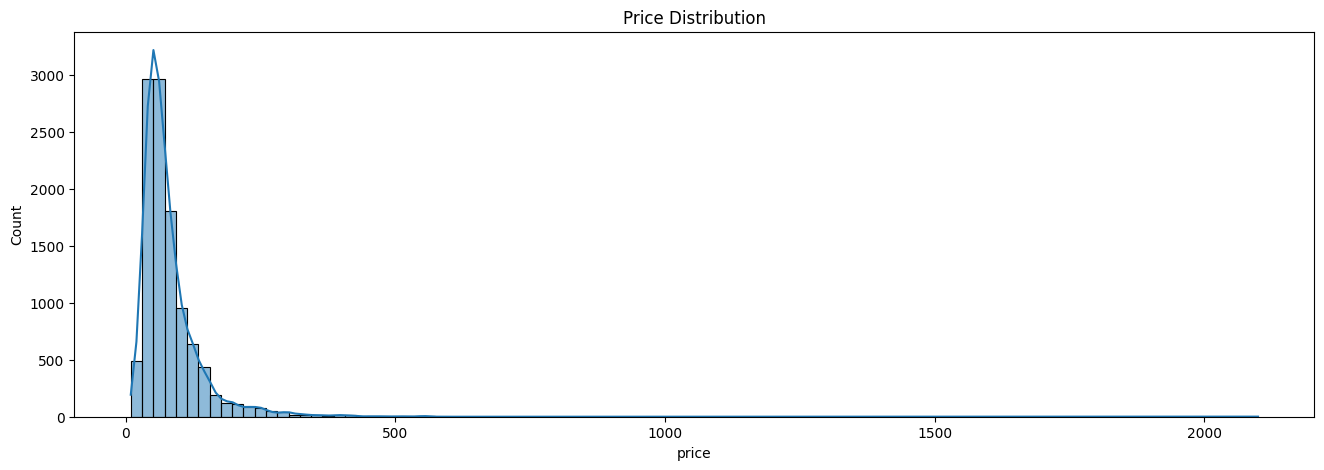

In [53]:
plt.figure(figsize=(16,5))
sns.histplot(df['price'],bins=100,kde=True)
plt.title('Price Distribution')

Text(0.5, 1.0, 'Price vs Sqft')

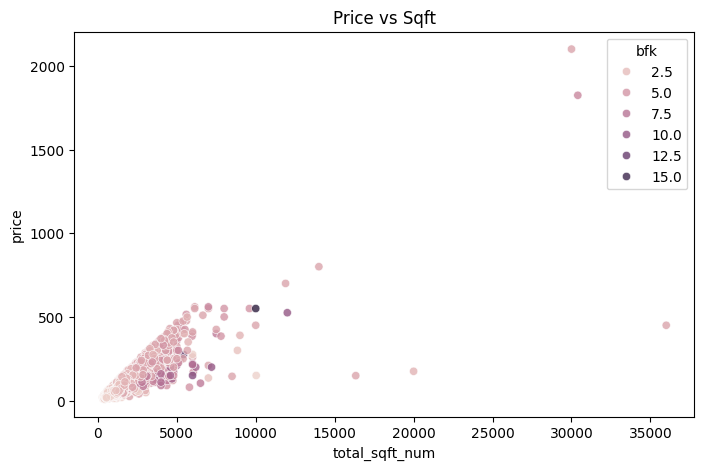

In [59]:
plt.figure(figsize=(8,5))
sns.scatterplot(data=df,x='total_sqft_num',y='price',hue='bfk',alpha=.8)
plt.title('Price vs Sqft')

In [60]:
x = df[['total_sqft_num','bath','balcony','bfk','location_slim']]
y = df['price']

In [61]:
num_features = ['total_sqft_num','bath','balcony','bfk']
cat_features = ['location_slim']

In [70]:
num_transformer = Pipeline(steps=[('imputer',SimpleImputer(strategy='median')),('scaler',StandardScaler())])
cat_transformer = Pipeline(steps=[('imputer',SimpleImputer(strategy='most_frequent')),('encoder',OneHotEncoder(handle_unknown='ignore'))])

preprocess = ColumnTransformer(transformers =[('num',num_transformer,num_features),('cat',cat_transformer,cat_features)])

x_train ,x_temp,y_train,y_temp = train_test_split(x,y,test_size=.4,random_state=69)
x_val,x_test,y_val,y_test= train_test_split(x_temp,y_temp,test_size=.2,random_state=69)

In [68]:
models = {
    'LinearRegression' : LinearRegression(),
    'RandomForest':RandomForestRegressor(n_estimators=150,random_state=69,n_jobs=-1),
    'GradientBoosting' : GradientBoostingRegressor(random_state=42)
}

In [76]:
results = []

for name ,model in models.items():
    pipe = Pipeline(steps=[('prep',preprocess),('model',model)])
    pipe.fit(x_train,y_train)
    preds = pipe.predict(x_val)
    mae = mean_absolute_error(y_val,preds)
    rmse = np.sqrt(mean_squared_error(y_val,preds))
    r2=r2_score(y_val,preds)
    results.append({'Model':name,"MAE":mae,'RMSE':rmse,'R2':r2})
    
results_df = pd.DataFrame(results).sort_values('MAE')
results_df

,Model,MAE,RMSE,R2
1,RandomForest,15.219729,29.636523,0.803198
2,GradientBoosting,16.876738,28.742298,0.814895
0,LinearRegression,18.477877,32.981661,0.756264
